# Prepping the final steps of PaddockTS

At this point, we can read in the Sentinel2 data plus indices, the Sentinel1 data, and the filtered paddock polygons, 
(and maybe some environmental data, but we're not going to worry about that in this script)

The next steps are, in order:
1. Generate paddock time series and save the raw versions in xarray form
2. perform interpolation and smoothing (include option for filtering of paddocks with too much missing data).
3. break it into paddock years. 
4. feature selection (SoS, EoS), potentially in future crop type classification.
5. Save dataframes for manual paddock use information. 

Plots:
paddock ts heatmaps. 



In [1]:

import numpy as np
import pickle
import xarray as xr
import rioxarray  # activate the rio accessor
import matplotlib.pyplot as plt 
import rasterio
import os
import shutil
import geopandas as gpd


from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [2]:
# ## SETUP"

# stub="MILG_0.01_2024"
# out_dir = "/g/data/xe2/jb5097/PaddockTS_Results/"
# tmp = "/scratch/xe2/jb5097/tmp/"


In [3]:
## OLDER SETUP
OLD=True

stub="TEST8"
out_dir = "/g/data/xe2/John/Data/PadSeg/"
tmp = "/g/data/xe2/John/Data/PadSeg/"


In [4]:
## FUNCTIONS

import numpy as np
import xarray as xr
from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def compute_median_for_time(t, band_array, transform, geometries):
    """
    Helper function that computes the zonal median for a single time step.
    
    Parameters:
        t (int): The time index.
        band_array (np.ndarray): A 3D numpy array (time, y, x) for the band.
        transform (Affine): Affine transform for the spatial mapping.
        geometries (list): List of shapely geometry objects.
    
    Returns:
        list: A list of median values, one for each geometry.
    """
    arr = band_array[t, :, :]
    stats = zonal_stats(
        vectors=geometries, 
        raster=arr, 
        affine=transform, 
        stats=['median'],
        nodata=np.nan
    )
    return [stat['median'] for stat in stats]

def summarize_medians_by_paddock(ds, pol):
    """
    Computes the median of each band in the xarray dataset 'ds' for each time step,
    over the areas defined by the geometries in the geopandas DataFrame 'pol',
    using parallel processing to speed up the computation.
    The resulting dataset uses the 'paddock' column (converted to string) of 'pol' as a coordinate.
    
    Parameters:
        ds (xarray.Dataset): Input dataset with dimensions (time, y, x) and band variables.
        pol (geopandas.GeoDataFrame): DataFrame with a 'geometry' column and a 'paddock' column.
        
    Returns:
        xarray.Dataset: A new dataset with coordinates 'paddock' and 'time'. Each variable is
                        named <band>_median and holds the median values computed for each paddock
                        and time step.
    """
    # Create an affine transform from the xarray coordinates.
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    transform = Affine.translation(x[0] - dx/2, y[0] - dy/2) * Affine.scale(dx, dy)
    
    # Convert paddock identifiers to strings.
    paddock_labels = pol.paddock.astype(str)
    
    # Prepare an empty dataset using the paddock names and time coordinates.
    ds_paddocks = xr.Dataset(coords={
        'paddock': paddock_labels,
        'time': ds.coords['time']
    })
    
    # Prepare the list of geometries (ensuring they are picklable for parallel processing).
    geometries = list(pol['geometry'])
    
    # Loop over each band variable in the dataset.
    for band in ds.data_vars:
        medians = np.empty((len(pol), ds.sizes['time']))
        band_array = ds[band].values  # shape: (time, y, x)
        
        # Create a partial function that fixes band_array, transform, and geometries.
        func = partial(compute_median_for_time, band_array=band_array, 
                       transform=transform, geometries=geometries)
        
        # Use parallel processing to compute the zonal median for each time step.
        with ProcessPoolExecutor() as executor:
            results = list(executor.map(func, range(ds.sizes['time'])))
        
        # Populate the medians array.
        for t, med in enumerate(results):
            medians[:, t] = med
        
        # Add the median values as a new variable in the output dataset.
        ds_paddocks[band] = (('paddock', 'time'), medians)
    
    return ds_paddocks

# Example usage:
# ds_paddocks = summarize_medians_by_paddock(ds, pol)
# print(ds_paddocks)

In [5]:
def resample_interpolate_smooth_paddocks(ds,
                                         days=10,
                                         window_length=7,
                                         polyorder=2):
    """
    Resample, conservatively interpolate, and smooth all time-dependent
    variables in a paddock-time xarray Dataset.

    The logic is identical to my function from ACT trees project:
      1. Separate non-time-dependent variables.
      2. Resample time-dependent data every `days` days (median).
      3. Interpolate missing values with PCHIP (conservative).
      4. Smooth with Savitzky–Golay.
      5. Re-attach static variables and return the new dataset.

        Parameters
    ----------
    ds : xarray.Dataset
        The input dataset.
    days : int, optional
        The resampling frequency in days (default is 10).
    window_length : int, optional
        The window length for the Savitzky–Golay filter (default is 7). This value must be odd. This is how many resampled obs the polynomial is fit to. 
    polyorder : int, optional
        The polynomial order for the Savitzky–Golay filter (default is 2). should be smaller than window_length. Higher orders let the filter follow curvature more closely but can re-introduce noise if the window is too short.
    """
    import numpy as np
    import xarray as xr
    from scipy.interpolate import PchipInterpolator
    from scipy.signal import savgol_filter

    # ─────────────────────────── 1. split vars ────────────────────────────
    time_dependent_vars = [v for v in ds.data_vars if "time" in ds[v].dims]
    non_time_dependent_vars = [v for v in ds.data_vars
                               if v not in time_dependent_vars]

    ds_non_time = ds[non_time_dependent_vars]  # may be empty
    ds_time_dep = ds[time_dependent_vars]

    # ─────────────────── 2. resample on a fixed grid ──────────────────────
    ds_resampled = ds_time_dep.resample(time=f"{days}D").median()
    ds_resampled = ds_resampled.transpose("paddock", "time")

    # ─────────────────── 3. interpolate with PCHIP ────────────────────────
    interp_dict = {}
    x = np.arange(ds_resampled.time.size)

    for var in time_dependent_vars:                           # loop over bands
        data = ds_resampled[var].values                       # (paddock, time)
        data_interp = np.empty_like(data, dtype=np.float64)

        for i in range(data.shape[0]):                        # loop paddocks
            y = data[i]
            valid = np.isfinite(y)                            # NaN or ±Inf safe
            if valid.sum() >= 2:
                try:
                    f = PchipInterpolator(x[valid], y[valid],
                                          extrapolate=True)
                    data_interp[i] = f(x)
                except ValueError:        # PCHIP can still fail (e.g. all equal)
                    data_interp[i] = np.nanmean(y) if valid.any() else np.nan
            else:
                data_interp[i] = np.nanmean(y) if valid.any() else np.nan

        # ─────────────── 4. Savitzky–Golay smoothing ────────────────
        wl = window_length + (window_length + 1) % 2           # make odd
        wl = min(wl, data_interp.shape[1] | 1)                 # ≤ n_time & odd
        data_smoothed = savgol_filter(data_interp,
                                      window_length=wl,
                                      polyorder=polyorder,
                                      axis=-1)
        interp_dict[var] = (("paddock", "time"), data_smoothed)

    # ─────────────────── 5. rebuild dataset ───────────────────────────────
    ds_new = ds_resampled.copy()
    for var, da in interp_dict.items():
        ds_new[var] = da
    for var in non_time_dependent_vars:
        ds_new[var] = ds_non_time[var]

    # keep original coords that might have been dropped (e.g. spatial_ref)
    for c in ds.coords:
        if c not in ds_new.coords:
            ds_new = ds_new.assign_coords({c: ds[c]})

    return ds_new


In [6]:
def split_paddockTS_by_year(ds):
    """
    Split paddock time series data by year, add day of year (doy) coordinate, and check for duplicate dates.
    
    Args:
        ds (xarray.Dataset): The input dataset containing time series data for each paddock.
        
    Returns:
        dict: A dictionary where each key is a year (int), and the value is an xarray.Dataset for that year,
              with an added 'doy' coordinate.
    """
    # Identify unique years in the 'time' coordinate (sorted)
    years = np.unique(ds.time.dt.year.values)
    
    # Dictionary to store datasets for each year
    datasets_by_year = {}
    
    for year in years:
        # Select data for the given year
        ds_year = ds.sel(time=ds.time.dt.year == year)

        # Useful bit of code if there are S1 data present, which can cause multi-obs on single day. 
        # # Check for multiple observations on the same date
        # dates = ds_year.time.dt.date.values
        # unique_dates, counts = np.unique(dates, return_counts=True)
        # duplicate_dates = unique_dates[counts > 1]
        
        # if duplicate_dates.size > 0:
        #     print(f"Multiple observations found on date(s) in {year}: {duplicate_dates}")
        # else:
        #     print(f"All observations in {year} occur on unique dates.")
        
        # Add an attribute for the year
        ds_year.attrs['year'] = int(year)
        
        # Calculate day of year (doy) from 'time' and add it as a new coordinate
        doy = ds_year.time.dt.dayofyear.data  # use .data to extract the underlying array
        ds_year = ds_year.assign_coords(doy=('time', doy))
        
        # Store the dataset in the dictionary
        datasets_by_year[int(year)] = ds_year

    return datasets_by_year

# Example usage:
# ds_paddock_years = split_paddockTS_by_year(ds_paddocks_ind)
# print(ds_paddock_years)

## MAIN

In [7]:
# ## Open the satellite data stack
# with open(out_dir+stub+'_ds2i.pkl', 'rb') as handle:
#     ds = pickle.load(handle)

# print(ds)

In [8]:
filename = f"{out_dir}{stub}_{'ds2.pkl' if OLD else 'ds2i.pkl'}"

with open(filename, "rb") as handle:
    ds = pickle.load(handle)

print(ds)


<xarray.Dataset>
Dimensions:           (time: 62, y: 205, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 2023-01-10T00:27:19.975577 ... 20...
  * y                 (y) float64 -4.424e+06 -4.424e+06 ... -4.426e+06
  * x                 (x) float64 1.388e+07 1.388e+07 ... 1.388e+07 1.388e+07
    spatial_ref       int32 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 792.0 797.0 ... 1.019e+03 1.117e+03
    nbart_green       (time, y, x) float32 1.037e+03 1.079e+03 ... 1.445e+03
    nbart_red         (time, y, x) float32 1.511e+03 1.558e+03 ... 2.1e+03
    nbart_red_edge_1  (time, y, x) float32 1.954e+03 1.954e+03 ... 2.136e+03
    nbart_red_edge_2  (time, y, x) float32 2.257e+03 2.257e+03 ... 2.286e+03
    nbart_red_edge_3  (time, y, x) float32 2.569e+03 2.569e+03 ... 2.642e+03
    ...                ...
    bg                (time, y, x) float64 0.06105 0.06536 ... 0.1206 0.09417
    pv                (time, y, x) float64 0.173 0.1579 ... 0.02063

In [9]:
# read in the polygons and plot:
pol = gpd.read_file(out_dir+stub+'_filt.gpkg')
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
#pol

In [10]:
ds_paddocks = summarize_medians_by_paddock(ds, pol)
print(ds_paddocks)

<xarray.Dataset>
Dimensions:           (time: 62, paddock: 18)
Coordinates:
  * time              (time) datetime64[ns] 2023-01-10T00:27:19.975577 ... 20...
    spatial_ref       int32 6933
  * paddock           (paddock) object '1' '2' '3' '4' ... '15' '16' '17' '18'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 653.0 813.0 ... 1.157e+03
    nbart_green       (paddock, time) float64 941.0 1.122e+03 ... 1.56e+03
    nbart_red         (paddock, time) float64 1.345e+03 1.587e+03 ... 2.271e+03
    nbart_red_edge_1  (paddock, time) float64 1.716e+03 2.022e+03 ... 2.562e+03
    nbart_red_edge_2  (paddock, time) float64 2.229e+03 2.644e+03 ... 2.743e+03
    nbart_red_edge_3  (paddock, time) float64 2.652e+03 3.072e+03 ... 3.103e+03
    ...                ...
    bg                (paddock, time) float64 0.02873 0.04326 ... 0.03971
    pv                (paddock, time) float64 0.2902 0.2443 ... 0.007019
    npv               (paddock, time) float64 0.6849 0.7095 ... 0.

In [11]:
# save the raw paddockTS
outdir = out_dir
out_name = os.path.join(outdir, stub + '_paddockTS_raw.pkl')
with open(out_name, 'wb') as f:
    pickle.dump(ds_paddocks, f, protocol=pickle.HIGHEST_PROTOCOL)
#logging.info(f"Data saved successfully to {out_name}")

In [12]:
## Set the rules for removing paddock years. 

## interpolate and resample

## break into paddock years

## feature extraction

## Save processed paddockTS as pickle

## Save paddock data as a csv



In [13]:
ds_paddocks_resample = resample_interpolate_smooth_paddocks(ds_paddocks,
                                         days=10,
                                         window_length=5,
                                         polyorder=2)
print(ds_paddocks_resample)

<xarray.Dataset>
Dimensions:           (paddock: 18, time: 73)
Coordinates:
  * paddock           (paddock) object '1' '2' '3' '4' ... '15' '16' '17' '18'
  * time              (time) datetime64[ns] 2023-01-10 2023-01-20 ... 2024-12-30
    spatial_ref       int32 6933
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 720.5 725.4 ... 934.1 1.229e+03
    nbart_green       (paddock, time) float64 1.017e+03 1.035e+03 ... 1.668e+03
    nbart_red         (paddock, time) float64 1.451e+03 1.541e+03 ... 2.448e+03
    nbart_red_edge_1  (paddock, time) float64 1.845e+03 1.904e+03 ... 2.765e+03
    nbart_red_edge_2  (paddock, time) float64 2.409e+03 2.339e+03 ... 2.964e+03
    nbart_red_edge_3  (paddock, time) float64 2.836e+03 2.73e+03 ... 3.357e+03
    ...                ...
    bg                (paddock, time) float64 0.03425 0.03176 ... 0.0647 0.02345
    pv                (paddock, time) float64 0.2673 0.1775 ... 0.01465 0.00307
    npv               (paddock, time) floa

In [14]:
ds_paddocks_resample_years = split_paddockTS_by_year(ds_paddocks_resample)
print(ds_paddocks_resample_years)

{2023: <xarray.Dataset>
Dimensions:           (paddock: 18, time: 36)
Coordinates:
  * paddock           (paddock) object '1' '2' '3' '4' ... '15' '16' '17' '18'
  * time              (time) datetime64[ns] 2023-01-10 2023-01-20 ... 2023-12-26
    spatial_ref       int32 6933
    doy               (time) int64 10 20 30 40 50 60 ... 310 320 330 340 350 360
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 720.5 725.4 734.0 ... 801.4 885.2
    nbart_green       (paddock, time) float64 1.017e+03 1.035e+03 ... 1.192e+03
    nbart_red         (paddock, time) float64 1.451e+03 1.541e+03 ... 1.653e+03
    nbart_red_edge_1  (paddock, time) float64 1.845e+03 1.904e+03 ... 1.844e+03
    nbart_red_edge_2  (paddock, time) float64 2.409e+03 2.339e+03 ... 2.017e+03
    nbart_red_edge_3  (paddock, time) float64 2.836e+03 2.73e+03 ... 2.306e+03
    ...                ...
    bg                (paddock, time) float64 0.03425 0.03176 ... 0.1048 0.09632
    pv                (paddock, 

## Next, find some methods to populate this dataset. 
TIMESAT 3.3 has some commonly used approaches that have been described in the literature. Go with them as a starter. By the way, they also have ways to process time series data like I have done above, but they also included a step for outlier removal. worth checking more closelyu. 

In [15]:
import pandas as pd
import numpy as np
import xarray as xr
import math
from scipy.signal import find_peaks


def make_phenology_template(
    ds_by_year: dict[int, xr.Dataset]
) -> pd.DataFrame:
    """
    Build a template DataFrame for storing phenology metrics for each
    paddock and year.

    Parameters
    ----------
    ds_by_year : dict[int, xr.Dataset]
        Mapping from year to an xarray.Dataset, each containing a
        'paddock' coordinate listing paddock IDs.

    Returns
    -------
    pd.DataFrame
        A DataFrame with one row per paddock-year, and columns:
        - paddock: paddock ID
        - year: calendar year
        - n_peaks: number of phenological peaks (init NaN)
        - SoS: start of season (day-of-year, init NaN)
        - PoS_val: peak-of-season value (init NaN)
        - PoS: peak-of-season time (day-of-year, init NaN)
        - MOS: middle-of-season value (init NaN)
        - EoS: end of season (day-of-year, init NaN)
        - pred_crop: predicted crop type (init None)
    """
    records: list[dict] = []
    for year, ds in ds_by_year.items():
        paddocks = ds.coords["paddock"].values
        for pad in paddocks:
            records.append({
                "paddock": pad,
                "year": year,
                # placeholder metrics:
                "n_peaks": np.nan,
                "SoS": np.nan,
                "PoS_val": np.nan,
                "PoS": np.nan,
                "MOS": np.nan,
                "EoS": np.nan,
                "pred_crop": None,
            })
    cols = [
        "paddock", "year", "n_peaks", "SoS",
        "PoS_val", "PoS", "MOS", "EoS", "pred_crop"
    ]
    return pd.DataFrame.from_records(records, columns=cols)


def add_num_peaks(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """
    Populate 'n_peaks' by counting peaks via scipy.find_peaks on each series.
    """
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            df.at[idx, 'n_peaks'] = 0
            continue
        series = ds[var].sel(paddock=row['paddock']).values
        valid = np.isfinite(series)
        if valid.sum() < 3:
            df.at[idx, 'n_peaks'] = 0
            continue
        height = np.nanquantile(series[valid], 0.75)
        dist = math.ceil(len(series)/4)
        peaks, _ = find_peaks(series, height=height, distance=dist)
        df.at[idx, 'n_peaks'] = len(peaks)
    return df


def add_peak_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Populate PoS_val and PoS with the max value and its day-of-year."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        # peak value and time
        val = da.max('time', skipna=True).item()
        t_idx = da.argmax('time', skipna=True).item()
        time = int(da['time.dayofyear'].isel(time=t_idx))
        df.at[idx, 'PoS_val'] = val
        df.at[idx, 'PoS'] = time
    return df


def add_middle_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """
    Populate MOS with the mean of the upper 80% slopes around the peak.
    """
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        # retrieve peak day-of-year from df
        peak_day = row['PoS']
        # split slopes
        left = da.where(da['time.dayofyear'] <= peak_day)
        right = da.where(da['time.dayofyear'] >= peak_day)
        # threshold at 80% max
        l80 = left.where(left >= left.max('time')*0.8)
        r80 = right.where(right >= right.max('time')*0.8)
        # average
        mos_val = float((l80.mean('time') + r80.mean('time')) / 2)
        df.at[idx, 'MOS'] = mos_val
    return df


def add_start_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Detect SoS (first positive slope) and fill SoS."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        peak = row['PoS']
        slope = da.where(da['time.dayofyear'] <= peak)
        diffs = slope.diff('time')
        pos = slope.where(diffs > 0)
        # choose first non-NaN
        times = pos['time.dayofyear'].values
        vals = pos.values
        # find first valid
        mask = np.isfinite(vals)
        if mask.any():
            first = np.argmax(mask)
            df.at[idx, 'SoS'] = int(times[first])
    return df


def add_end_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Detect EoS as first negative slope after peak and fill EoS."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        peak = row['PoS']
        slope = da.where(da['time.dayofyear'] >= peak)
        diffs = slope.diff('time')
        neg = slope.where(diffs < 0)
        times = neg['time.dayofyear'].values
        vals = neg.values
        mask = np.isfinite(vals)
        if mask.any():
            first = np.argmax(mask)
            df.at[idx, 'EoS'] = int(times[first])
    return df

# Example pipeline:
# df = make_phenology_template(ds_by_year)
# df = add_num_peaks(df, ds_by_year, "nbart_red")
# df = add_peak_of_season(df, ds_by_year, "nbart_red")
# df = add_middle_of_season(df, ds_by_year, "nbart_red")
# df = add_start_of_season(df, ds_by_year, "nbart_red")
# df = add_end_of_season(df, ds_by_year, "nbart_red")
# print(df.head())


In [16]:
df = make_phenology_template(ds_paddocks_resample_years)
df = add_num_peaks(df, ds_paddocks_resample_years, "NDVI")
df = add_peak_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_middle_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_start_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_end_of_season(df, ds_paddocks_resample_years, "NDVI")
df.head()


,paddock,year,n_peaks,SoS,PoS_val,PoS,MOS,EoS,pred_crop
0,1,2023,2.0,100.0,0.711912,280.0,0.656595,290.0,None
1,2,2023,2.0,20.0,0.726961,290.0,0.674233,300.0,None
2,3,2023,1.0,90.0,0.905892,250.0,0.870142,260.0,None
3,4,2023,1.0,20.0,0.884405,290.0,0.826199,300.0,None
4,5,2023,1.0,20.0,0.882725,290.0,0.826242,300.0,None


/jobfs/140995184.gadi-pbs/ipykernel_1432822/3491705839.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.loc[(df.paddock == pad) & (df.year == yr), 'n_peaks'])


Paddock 18, 2024: 1 peak(s)
Paddock 14, 2023: 1 peak(s)
Paddock 13, 2023: 2 peak(s)


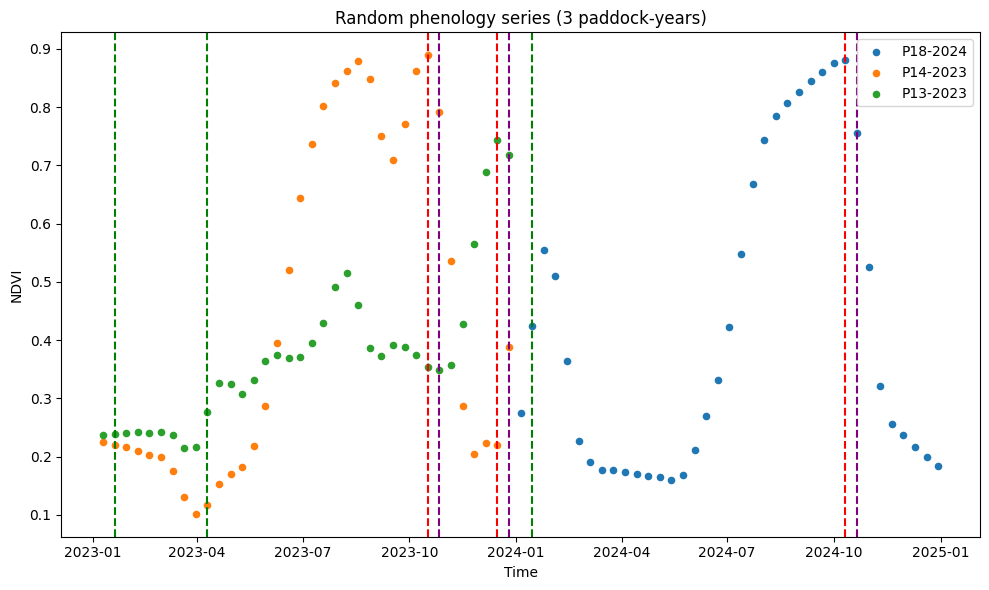

In [17]:

def plot_phenology_random(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI",
    N: int = 3,
    seed: int | None = None,
    unit_dim: str = "paddock",
    time_dim: str = "time"
):
    """
    Scatter-plot `var` time series for `N` random paddock-year entries,
    with vertical lines at SoS (green), PoS (red), and EoS (purple),
    and print number of peaks per series.
    """
    rng = np.random.default_rng(seed)
    # list of (paddock, year)
    pairs = list(zip(df['paddock'], df['year']))
    if N > len(pairs):
        raise ValueError("N exceeds number of paddock-year entries")
    indices = rng.choice(len(pairs), size=N, replace=False)

    plt.figure(figsize=(10, 6))
    for i in indices:
        pad, yr = pairs[i]
        ds = ds_by_year.get(yr)
        series = ds[var].sel({unit_dim: pad})
        times = series[time_dim].values
        values = series.values
        # print peaks
        n = int(df.loc[(df.paddock == pad) & (df.year == yr), 'n_peaks'])
        print(f"Paddock {pad}, {yr}: {n} peak(s)")
        # scatter plot
        plt.scatter(times, values, s=20, label=f"P{pad}-{yr}")
        # annotate vertical lines
        row = df[(df.paddock == pad) & (df.year == yr)].iloc[0]
        for metric, color in [('SoS', 'green'), ('PoS', 'red'), ('EoS', 'purple')]:
            day = int(row[metric])
            date = np.datetime64(f"{yr}-01-01") + np.timedelta64(day-1, 'D')
            plt.axvline(date, color=color, linestyle='--')

    plt.xlabel('Time')
    plt.ylabel(var)
    plt.title(f"Random phenology series ({N} paddock-years)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_phenology_random(df, ds_paddocks_resample_years)

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_variable_panels(df, ds_dict, variable):
    """
    Scatter-plots of `variable` for each paddock (rows) and year (columns),
    annotated with SoS, PoS, EoS, paddock ID, and n_peaks. 

    Panel size: 3″ wide by 2″ high; overall figsize = (3*cols, 2*rows).
    """
    years = sorted(ds_dict.keys())
    paddocks = sorted(df['paddock'].unique())
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            ds_year = ds_dict[year]
            if str(paddock) not in ds_year['paddock'].values:
                ax.set_axis_off()
                continue

            da = ds_year[variable].sel(paddock=str(paddock))
            doy = ds_year['doy'].values

            # scatter time series
            ax.scatter(doy, da.values, s=10)

            # title for the top row
            if i == 0:
                ax.set_title(f"{year}", pad=8)

            row = df[(df['paddock'] == paddock) & (df['year'] == year)]
            if not row.empty:
                r = row.iloc[0]
                # colored vertical lines
                ax.axvline(r['SoS'], color='green', linestyle='--')
                ax.axvline(r['PoS'], color='blue', linestyle='-.')
                ax.axvline(r['EoS'], color='red', linestyle=':')

                # white box behind text
                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes, va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['n_peaks'])}", transform=ax.transAxes, va='top', bbox=bbox)
                if pd.notna(r.get('pred_crop', None)):
                    ax.text(0.95, 0.88, f"crop: {r['pred_crop']}",
                            transform=ax.transAxes, ha='right', va='top', bbox=bbox)

            # axis labels
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")

    fig.tight_layout()
    plt.show()

# Example usage:
# plot_variable_panels(df, ds_paddocks_resample_years, 'NDVI')




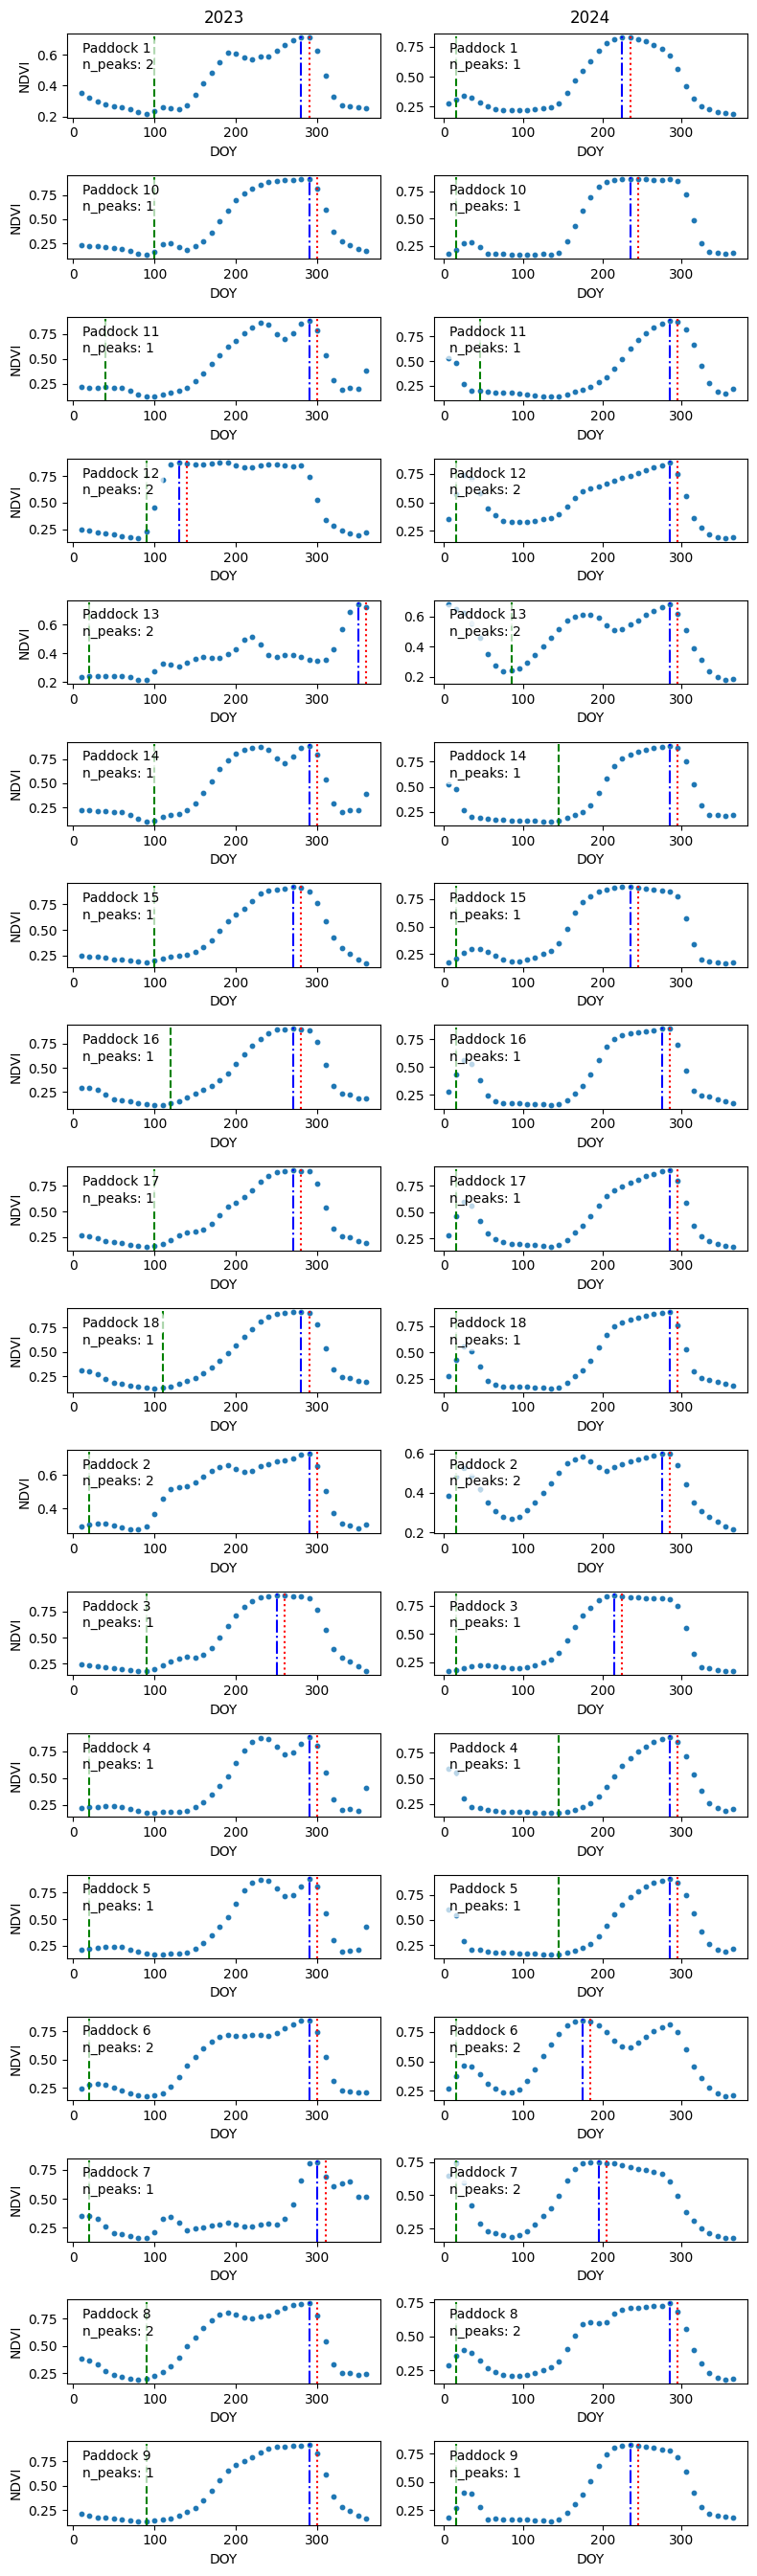

In [19]:
plot_variable_panels(df, ds_paddocks_resample_years, 'NDVI')

##  Plotting functions for another script

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(ds, variable_name):
    """
    Plots a heatmap for the specified variable in the dataset.
    
    Parameters:
        ds (xarray.Dataset): Dataset with 'paddock' and 'time' as coordinates.
        variable_name (str): Name of the variable to plot (e.g., 'nbart_blue_median').
    """
    # Convert the DataArray into a pandas DataFrame
    # The index will be paddocks and columns will be time.
    df = ds[variable_name].to_pandas()
    
    # Format the dates as YYYY-MM-DD (assuming the columns are a DatetimeIndex)
    if isinstance(df.columns, pd.DatetimeIndex):
        df.columns = df.columns.strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap without annotations and with a shrunken colorbar.
    ax = sns.heatmap(df, cmap="viridis", annot=False, cbar_kws={"shrink": 0.5})
    
    # Set the colorbar title to the variable name.
    colorbar = ax.collections[0].colorbar
    colorbar.set_label(variable_name)
    
    # Set axis labels
    ax.set_xlabel("Observation Date")
    ax.set_ylabel("Paddock")
    
    # Rotate paddock (row) labels to be horizontal.
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # No plot title is set.
    plt.show()

# Example usage:
# plot_heatmap(ds_paddocks, 'nbart_blue_median')

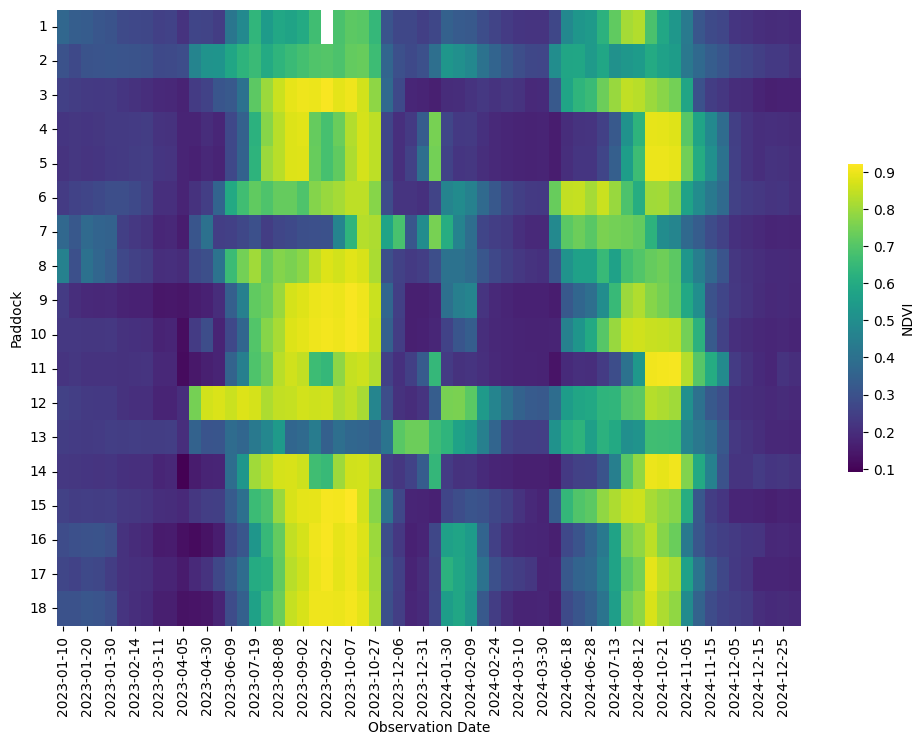

In [21]:
plot_heatmap(ds_paddocks, 'NDVI')

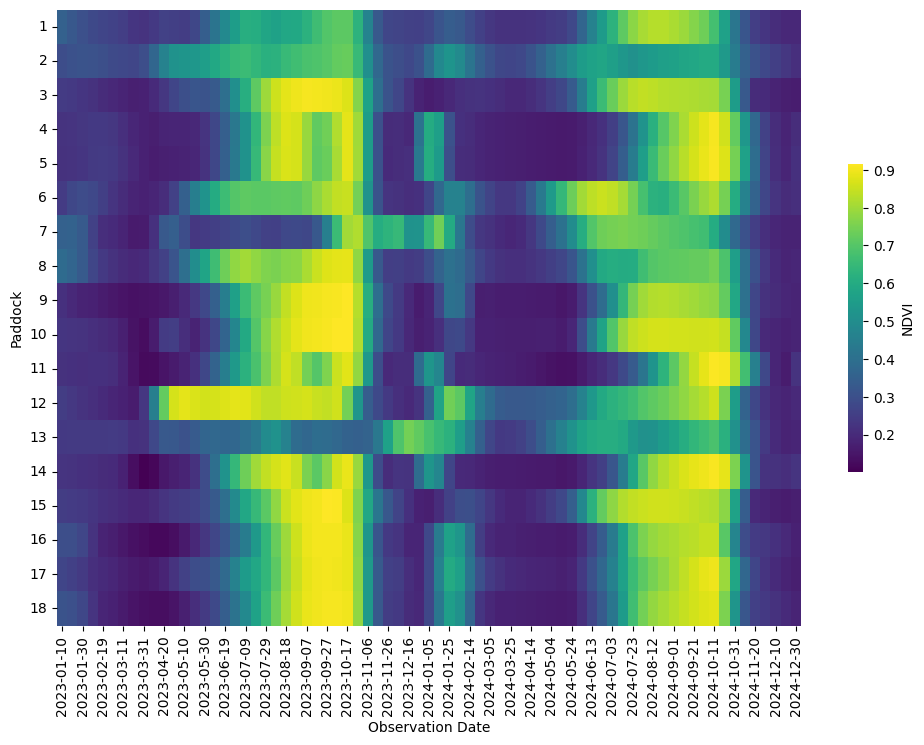

In [22]:
plot_heatmap(ds_paddocks_resample, 'NDVI')

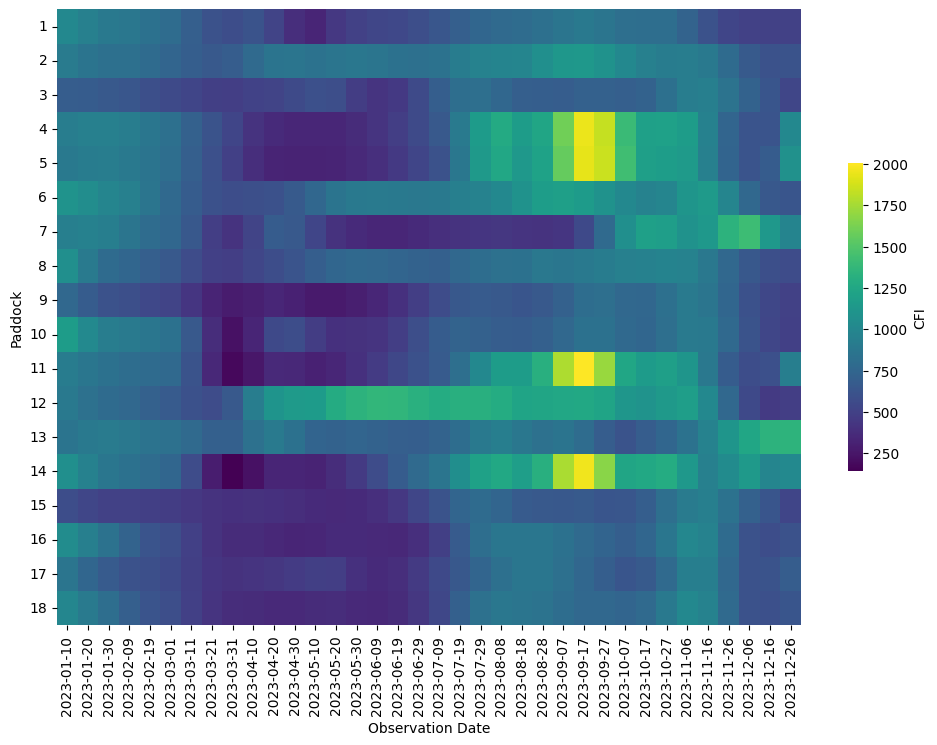

In [23]:
plot_heatmap(ds_paddocks_resample_years[2023], 'CFI')

In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_gap_lengths_by_year(ds: xr.Dataset,
                             var: str = "nbart_red",
                             *,
                             unit_dim: str = "paddock",
                             time_dim: str = "time",
                             min_gap_days: int = 1,
                             bins: int | str = "auto",
                             figsize: tuple[int, int] = (6, 4),
                             show: bool = True) -> dict[int, list[int]]:
    """
    Histogram of calendar-day gaps between successive valid observations.

    • Left y-axis  : absolute count of gaps.
    • Right y-axis : count ÷ number-of-paddocks (tick labels rounded).

    A red dotted vertical line marks `min_gap_days`; x-axis spans [min, max].
    """
    if var not in ds.data_vars:
        raise KeyError(f"{var!r} not found in dataset.")

    da = ds[var]
    n_units = ds.dims[unit_dim]    # total paddocks

    def _gaps_in_days(times: np.ndarray) -> np.ndarray:
        if times.size < 2:
            return np.empty(0, dtype=int)
        deltas = np.diff(np.sort(times.astype("datetime64[D]")))
        return deltas.astype("timedelta64[D]").astype(int)

    gap_dict: dict[int, list[int]] = {}

    for yr, da_year in da.groupby(f"{time_dim}.year"):
        gaps_all: list[int] = []
        for unit in da_year[unit_dim]:
            times = da_year.sel({unit_dim: unit}).dropna(time_dim)[time_dim].values
            gaps_all.extend(_gaps_in_days(times))

        gap_dict[yr] = [g for g in gaps_all if g >= min_gap_days]

        if show:
            fig, ax = plt.subplots(figsize=figsize)

            # histogram
            counts, edges, _ = ax.hist(gaps_all, bins=bins,
                                       edgecolor="black", alpha=0.7)

            # secondary y-axis: same scale, labels = counts/n_units (rounded)
            ax2 = ax.twinx()
            ax2.set_ylim(ax.get_ylim())
            primary_ticks = ax.get_yticks()
            ax2.set_yticks(primary_ticks)
            ax2.set_yticklabels([str(int(round(y / n_units))) for y in primary_ticks])
            ax2.set_ylabel("gaps per paddock")

            # red dotted threshold
            ax.axvline(min_gap_days, color="red", linestyle="dotted",
                       linewidth=1.5, label=f"threshold = {min_gap_days} d")

            # axis limits
            if gaps_all:
                ax.set_xlim(min(gaps_all), max(gaps_all))
            else:
                ax.set_xlim(0, 1)

            ax.set_xlabel("gap length (days)")
            ax.set_ylabel("number of gaps")
            ax.set_title(f"{var} – gap lengths, {yr}")
            ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    return gap_dict



/jobfs/140995184.gadi-pbs/ipykernel_1432822/2260889710.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_units = ds.dims[unit_dim]    # total paddocks


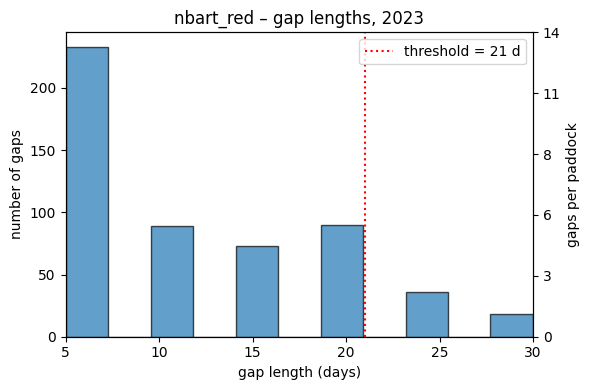

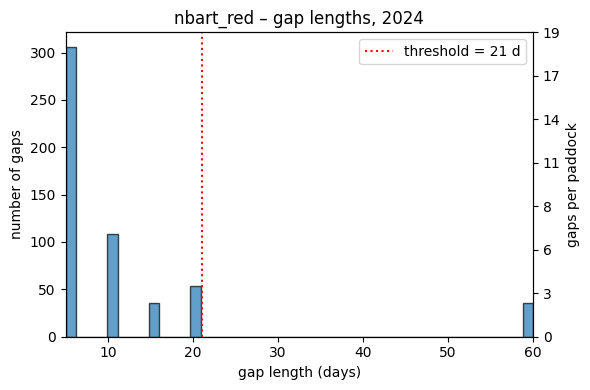

In [25]:
gap_stats = plot_gap_lengths_by_year(ds_paddocks,
                                     var="nbart_red",
                                     min_gap_days=21)
# Next time, the threshold should indicate a red dotted line, and the domain should cover min to max. 

In [26]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_random_paddock_series(ds: xr.Dataset,
                               var: str = "nbart_red",
                               N: int = 3,
                               seed: int | None = None,
                               unit_dim: str = "paddock",
                               time_dim: str = "time",
                               interval_days: int = 10):
    """
    Scatter-plot `var` vs. time for `N` random paddocks, with faint
    vertical lines every `interval_days` to highlight data gaps.
    """
    if var not in ds:
        raise KeyError(f"{var!r} not found in dataset.")

    rng = np.random.default_rng(seed)
    paddock_ids = ds[unit_dim].values
    if N > len(paddock_ids):
        raise ValueError("N exceeds number of paddocks.")
    chosen = rng.choice(paddock_ids, size=N, replace=False)

    # ── build the background grid of vertical lines ────────────────
    tmin = ds[time_dim].values.min().astype("datetime64[D]")
    tmax = ds[time_dim].values.max().astype("datetime64[D]")
    vlines = np.arange(tmin, tmax + np.timedelta64(interval_days, "D"),
                       np.timedelta64(interval_days, "D"))

    plt.figure(figsize=(8, 4))

    # draw grid first (low z-order so scatter sits on top)
    for v in vlines:
        plt.axvline(v, color="lightgray", linewidth=0.8, zorder=0)

    # ── scatter each sampled paddock ───────────────────────────────
    for pid in chosen:
        da = ds[var].sel({unit_dim: pid})
        plt.scatter(da[time_dim], da, s=15, label=f"{unit_dim} {pid}")

    plt.xlabel("Time")
    plt.ylabel(var)
    plt.title(f"{var} – {N} random paddocks")
    plt.legend()
    plt.tight_layout()
    plt.show()


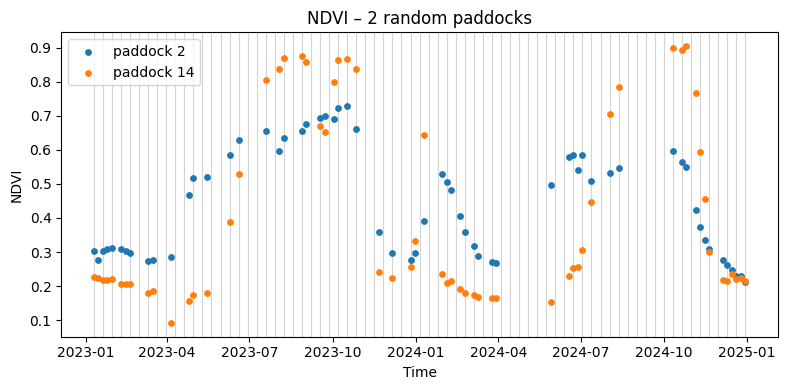

In [27]:
# plot nbart_red for 4 random paddocks
plot_random_paddock_series(ds_paddocks, var="NDVI", N=2, seed=42)

## Trying to run phenolpy directly:


In [28]:
import sys
sys.path.append('/g/data/xe2/John/Software/PhenoloPy/scripts')
import phenolopy

In [29]:
ds_paddocks_resample_years

{2023: <xarray.Dataset>
 Dimensions:           (paddock: 18, time: 36)
 Coordinates:
   * paddock           (paddock) object '1' '2' '3' '4' ... '15' '16' '17' '18'
   * time              (time) datetime64[ns] 2023-01-10 2023-01-20 ... 2023-12-26
     spatial_ref       int32 6933
     doy               (time) int64 10 20 30 40 50 60 ... 310 320 330 340 350 360
 Data variables: (12/16)
     nbart_blue        (paddock, time) float64 720.5 725.4 734.0 ... 801.4 885.2
     nbart_green       (paddock, time) float64 1.017e+03 1.035e+03 ... 1.192e+03
     nbart_red         (paddock, time) float64 1.451e+03 1.541e+03 ... 1.653e+03
     nbart_red_edge_1  (paddock, time) float64 1.845e+03 1.904e+03 ... 1.844e+03
     nbart_red_edge_2  (paddock, time) float64 2.409e+03 2.339e+03 ... 2.017e+03
     nbart_red_edge_3  (paddock, time) float64 2.836e+03 2.73e+03 ... 2.306e+03
     ...                ...
     bg                (paddock, time) float64 0.03425 0.03176 ... 0.1048 0.09632
     pv          

In [30]:
which_var = 'NDVI'

ds_veg_index = ds_paddocks_resample_years[2023][[which_var]] \
             .rename({which_var: 'veg_index'})

da_num_seasons = phenolopy.calc_num_seasons(ds=ds_veg_index)

Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!



In [31]:
# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(da=ds_veg_index['veg_index'], 
                                        peak_metric='pos', 
                                        base_metric='vos', 
                                        method='seasonal_amplitude', 
                                        factor=0.2, 
                                        thresh_sides='two_sided', 
                                        abs_value=0.1)
ds_phenos

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

MergeError: conflicting values for variable 'time' on objects to be combined. You can skip this check by specifying compat='override'.